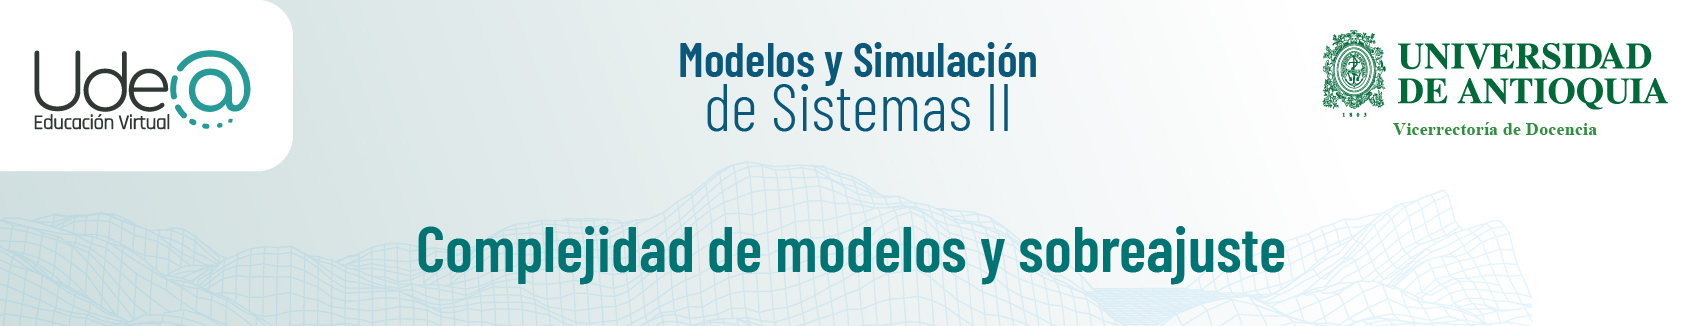

# **<font size= 1> <font color='FFFFFF'>Complejidad de modelos </font>**

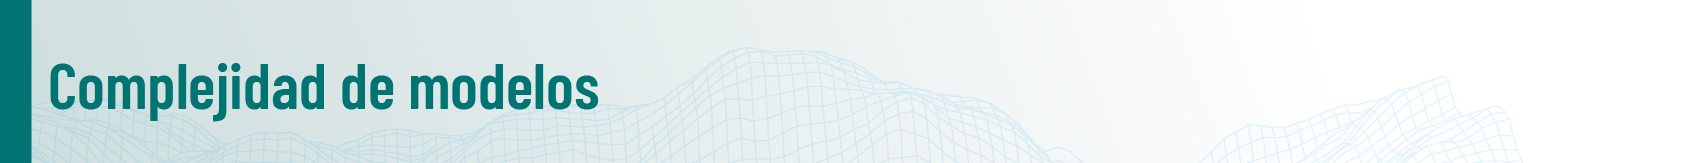

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression

class PolynomialLinearRegression:
    def __init__(self, degree):
        self.degree = degree
        self.model = LinearRegression()
        
    def fit(self, X,y):
        self.model.fit(np.vander(X, self.degree + 1), y)
        
    def predict(self, X):
        return self.model.predict(np.vander(X, self.degree + 1))

    def score(self, X, y):
        # rmse
        return np.sqrt(np.mean((y-self.predict(X))**2))

def f(size):
    '''
    Returns a sample with 'size' instances without noise.
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5)
    return (x,y)

def sample(size):
    '''
    Returns a sample with 'size' instances.
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5) + np.random.randn(x.size)
    return (x,y)

## <font color='007473'> **Bias vs. Variance**

In [ ]:
plt.figure(figsize=(18,3))
for k, degree in enumerate([3, 5, 10, 18]):
    plt.subplot(1,4,k+1)
    n_samples = 20
    n_models = 20
    avg_y = np.zeros(n_samples)
    for i in range(n_models):
        (x,y) = sample(n_samples)
        model = PolynomialLinearRegression(degree=degree)
        model.fit(x,y)
        p_y = model.predict(x)
        avg_y = avg_y + p_y
        plt.plot(x, p_y, 'k-', alpha=.1)
    avg_y = avg_y / n_models
    plt.plot(x, f(len(x))[1], 'b--', color="red", lw="3", alpha=.5, label="actual function")
    plt.legend();
    plt.grid();
    plt.title("degree %d"%degree)

In [ ]:
from numpy.linalg import norm
n_samples = 20
f_x, f_y = f(n_samples)
n_models = 100
max_degree = 15
var_vals =[]
bias_vals = []
error_vals = []
for degree in range(1, max_degree):
    avg_y = np.zeros(n_samples)
    models = []
    for i in range(n_models):
        (x,y) = sample(n_samples)
        model = PolynomialLinearRegression(degree=degree)
        model.fit(x,y)
        p_y = model.predict(x)
        avg_y = avg_y + p_y
        models.append(p_y)
    avg_y = avg_y / n_models
    bias_2 = norm(avg_y - f_y)/f_y.size
    bias_vals.append(bias_2)
    variance = 0
    for p_y in models:
        variance += norm(avg_y - p_y)
    variance /= f_y.size * n_models
    var_vals.append(variance)
    error_vals.append(variance + bias_2)
plt.plot(range(1, max_degree), bias_vals, label='bias')
plt.plot(range(1, max_degree), var_vals, label='variance')
plt.plot(range(1, max_degree), error_vals, label='error = bias+variance')
plt.legend()
plt.xlabel("polynomial degree")
plt.grid();

-------------------

# <font size= 1> <font color='FFFFFF'>**Metodologías de validación</font>**

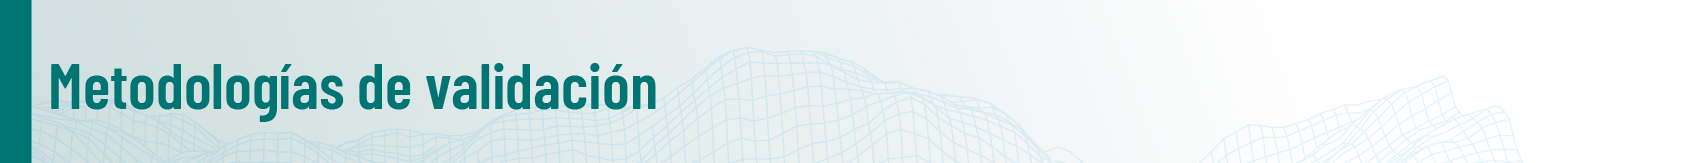

## <font color='007473'>**Validación cruzada ($k$-fold cross-validation)**

<br>Diagrama: https://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Modelo de K vecinos más cercanos
# n_neighbors = [1,3,5,7]

def FronterasCV(X,Y, cv):
    nf = cv.get_n_splits(X)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Acc = np.zeros((4,nf))
    fold = 0
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
    for train_index, val_index in cv.split(X):
        fold += 1
        #------------------------------------
        Xtrain = X[train_index,:]
        Ytrain = Y[train_index]
        Xval = X[val_index,:]
        Yval = Y[val_index]
        #------------------------------------
        for i,n_neighbors in enumerate([1,3,5,7]):
            if fold == 1:
                ax[i].scatter(X[:,0],X[:,1],c=Y.flatten(), cmap='Set2',alpha=0.5)
                ax[i].set_title('Fronteras para k='+str(n_neighbors))
                ax[i].set_xlabel('$x_1$')
                ax[i].set_ylabel('$x_2$')
                ax[i].grid()
            
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(Xtrain,Ytrain.flatten())
            Ypred = clf.predict(Xval)
            Acc[i,fold-1] = accuracy_score(Yval,Ypred)
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            ax[i].contour(xx, yy, Z, cmap=plt.cm.Blues)
        
    plt.show()
    return(Acc)

Graficando modelos con diferentes *k*.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Comparando los modelos de vecinos más cercanos # n_neighbors = [1,3,5,7]

N = 1000
Cov = np.identity(2) * 1.1
Cov2 = np.array([[1.1,0.5],[0.5,1.1]])
Mean = [1.1,2.1]
Mean2 = [4.1,4.1]
x, y  = np.random.multivariate_normal(Mean, Cov, N).T
x2, y2  = np.random.multivariate_normal(Mean2, Cov2, N).T
X = np.r_[np.c_[x,y],np.c_[x2,y2]]
Y = np.r_[np.ones((N,1)),np.zeros((N,1))]
#----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

kf = KFold(n_splits=4)
Acc = FronterasCV(X_train,y_train, kf)
print('Accuracy en cada fold = '+ np.array_str(Acc))
print('Accuracy promedio = '+str(np.mean(Acc,axis=1)) + '+/-' +str(np.std(Acc,axis=1)*2))

**El mejor modelo fue para un $k=7$**

In [ ]:
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train,y_train.flatten())
y_pred = clf.predict(X_test)
print('Accuracy en test = ' + str(accuracy_score(y_test,y_pred)))

Accuracy en test = 0.9475


## <font color='007473'>**Leave-one-out**
Librería: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html

In [ ]:
from sklearn.model_selection import LeaveOneOut
n=10
kf = KFold(n_splits=n)

## <font color='007473'> **Validación bootstrapping (shuffle-split)**
Librería: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit

In [ ]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
Acc = FronterasCV(X_train,y_train, rs)
print('Accuracy en cada fold = '+ np.array_str(Acc))
print('Accuracy promedio = '+str(np.mean(Acc,axis=1)) + '+/-' +str(np.std(Acc,axis=1)*2))

## <font color='007473'>**Problemas desbalanceados**



In [ ]:
#Versión de validación cruzada estratificada
from sklearn.model_selection import StratifiedKFold

In [ ]:
#Versión de validación Bootstrapping estratificada
from sklearn.model_selection import StratifiedShuffleSplit

# <font size= 1> <font color='FFFFFF'>**Curva de aprendizaje</font>**
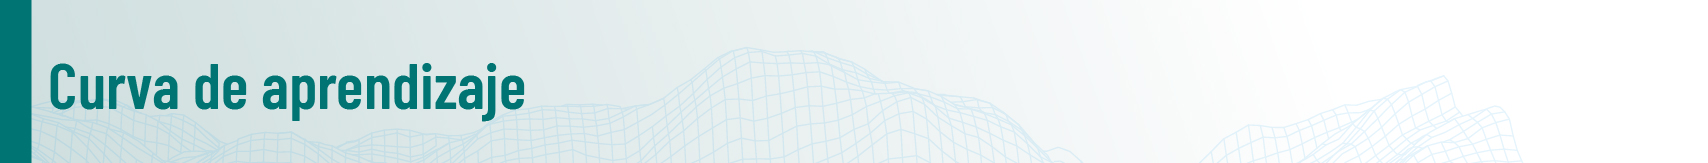

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xtrain = scaler.fit_transform(X)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

title = "Learning Curves (Random Forest, n_estimators=20)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

#estimator = KNeighborsClassifier(n_neighbors=9, metric='minkowski', p=1)
estimator = RandomForestClassifier(n_estimators=20 ,max_depth=3, random_state=0)
plot_learning_curve(estimator, title, Xtrain, Y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, Y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

**Prueba con otro conjunto de datos**

In [ ]:
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

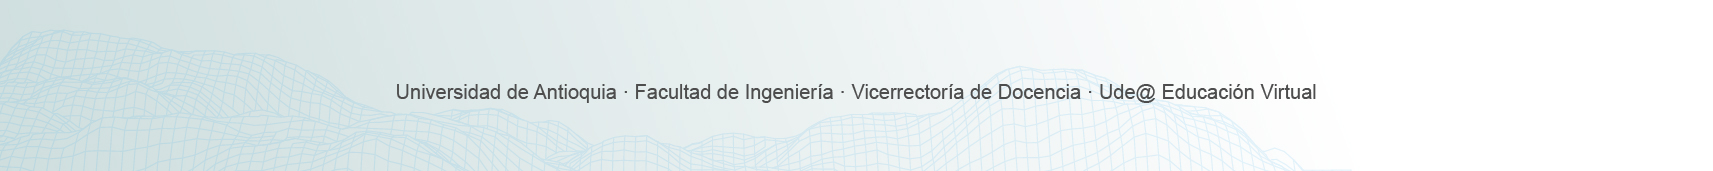